In [1]:
import Image_preperation as prep
import numpy as np
import matplotlib.pyplot as plt
import math
import FileManager as fm
import cv2

def fit_measure(points, length, edge_img):
    
    size = len(points)
    new_points = np.empty((size,2))
    total_error = 0
    
    for i in range(size):
        #print(i)
        if(i==size-1):
            p1, p2, p3 = points[i-1], points[i], points[0] 
        else:
            p1, p2, p3 = points[i-1], points[i], points[i+1]

        p2_new = strongest_edge_point_on_normal(p1, p2, p3 ,length, edge_img)
        #print(p2_new)
        total_error += error_measure(p2, p2_new)
        new_points[i] = p2_new
        
    return new_points, total_error;   
        
def error_measure(p1, p2):
    
    x1, y1 = p1
    x2, y2 = p2
    #dist = sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    return math.hypot(x2 - x1, y2 - y1)
    
         
def strongest_edge_point_on_normal(a,b,c,length, edge_img):
    
    rad = get_normal_angle(a,b,c)
    points = get_points_on_angle(b, rad, length)
    edge_strength = edge_strength_at_points(points, edge_img)
    id_edge_point = np.argmax(edge_strength)
    edge_point = points[id_edge_point]

    return edge_point

def edge_strength_on_normal(a,b,c,length, edge_img):
    
    rad = get_normal_angle(a,b,c)
    points = get_points_on_angle(b, rad, length)
    return edge_strength_at_points(points, edge_img)

def is_horizontal(a,b,c):
    if(a[1] == b[1] and b[1] == c[1]):
        return True
    return False
    
def is_vertical(a,b,c):
    if(a[0] == b[0] and b[0] == c[0]):
        return True
    return False

def is_equal(b_proj , b):
    return np.array_equal(b_proj, b)


def get_normal_angle(a,b,c):
    if( is_horizontal(a,b,c) ):
        return math.pi/2
    if( is_vertical(a,b,c) ):
        return 0
    
    b_proj = project_on(b, a,c)
        
    #is linear
    if(is_equal(b_proj , b)):
        
        b_norm = np.add(b,[2,0])
        rad = calc_angle(a,b,b_norm)

    #not linear
    else:
        b_norm = np.add(b, [2,0])
        rad = calc_angle(b_proj, b, b_norm)
    
    #rad given back relative to x-axis
    if( b_norm[0] > b[0]):
        if (b_proj[1] > b_norm[1]):
            return rad
        else:
            return -rad
    else:
        if( b_proj[1] > b_norm[1]):
            return -rad
        else:
            return rad

def get_normal_angle2(a,b,c):
    if( is_horizontal(a,b,c) ):
        return math.pi/2
    if( is_vertical(a,b,c) ):
        return 0
    
    b_proj = project_on(b, a,c)
    
    if(is_equal(b_proj , b)):
        c_norm = np.add(c,[2,0])
        if(is_equal(a,b)):
            a_corr = np.add(a,[-5,0])
            a_proj = project_on(a_corr, b ,c)
            return calc_angle(a_proj,b,c_norm)
        return calc_angle(a,b,c_norm)
    
    b_norm = np.add(b, [2,0])
    
    return calc_angle(b_proj, b, b_norm)

def project_on(x, a,c):
    n = np.subtract(a, c)
    n = np.divide(n, np.linalg.norm(n, 2))

    return c + n*np.dot(np.subtract(x , c), n)

def calc_angle(a,b,c):
    
    ba = np.subtract(a, b)
    bc = np.subtract(c , b)

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    if(np.isnan(angle)):
        print(a)
        print(b)
        print(c)
    return angle


def get_point_at_distance(point, dist, rad):
    new_point = np.zeros_like(point)
    y = int(np.around(math.sin(rad) * dist))
    x = int(np.around(math.cos(rad) * dist))
    new_point[0] = point[0] + x
    new_point[1] = point[1] + y
    return new_point

def get_points_on_angle(point, rad, length):
    
    points = np.empty((2*length+1, 2))
    points[0] = point
    for i, x in enumerate(range(1,length+1)):

        points[2*i+1] = get_point_at_distance(point, x, rad)
        points[2*i+2] = get_point_at_distance(point, -x, rad)
        
    return points

def get_points_on_angle_normal(point, rad, length):
    
    points = np.empty((2*length+1, 2))
    for i, x in enumerate(range(-length,length+1)):

        points[i] = get_point_at_distance(point, x, rad)
        
    return points

def edge_strength_at_points(points ,edge_img):
    
    gradient = np.empty(len(points))
    for i, p in enumerate(points):
        gradient[i] = edge_img[int(p[1]),int(p[0])]
        
    return gradient

def normalize(x):
    return x / np.linalg.norm(x)

def make_line(img_copy, p1,p2):
     cv2.line(img_copy,(p1[0],p1[1]),(p2[0],p2[1]),(255,0,0),1)

def load_tooth(i):
    init = np.load("initial_position.npy")
    return init[0,i,:,:]/0.3

def load_tooth_of_piece():
    tooth = load_tooth(4)
    tooth_of_piece = tooth
    tooth_of_piece[:,0]=tooth[:,0]-1200
    tooth_of_piece[:,1]=tooth[:,1]-700
    return tooth_of_piece

def load_img_piece():
    img = load_image()
    return img[700:1300,1200:1800]

def show_with_points(img, points):
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.imshow(img)
    plt.plot(points[:,0], points[:,1], 'ro', markersize=4)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
def test_normal_on_edge():
    
    piece = fm.load_img_piece()
    new_pice = piece[300:450,100:250]

    tooth = fm.load_tooth_of_piece()
    points = tooth
    
    fm.show_with_points(piece, points)
    
    new_points = np.copy(points)
    new_points[:,0]=points[:,0]-100
    new_points[:,1]=points[:,1]-300
    
    a,b,c = new_points[0:3]
    rad = get_normal_angle(a,b,c)
    p1 = get_point_at_distance(b, 20, rad)
    p2 = get_point_at_distance(b, -20, rad)
    img_copy = new_pice.copy()
    p1 = np.array(p1,dtype=int)
    p2 = np.array(p2,dtype=int)
    make_line(img_copy, p1,p2)
    
    visualize_points = new_points.take([38,39,0,1,2,3],axis=0)
    proj = project_on(b, a,c)
    visualize_points = np.append(visualize_points,proj).reshape(-1,2)
    
    show_with_points(img_copy,visualize_points)
    
    edges = get_points_on_angle_normal(b, rad, 20)
    edge_img = prep.edge_detection_high(new_pice)
    strength = edge_strength_at_points(edges ,edge_img)
    
    show_with_points(new_pice,edges)
    
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.plot(np.arange(-20,21),strength)
    plt.show()
    
    
def show_results_fitting():
    piece = fm.load_img_piece()
    edge_img = prep.canny(piece)
    tooth = fm.load_tooth_of_piece(0)
    new_points_list, total_error = fit_measure(tooth, 30, edge_img)
    for i in range(7):
        tooth = fm.load_tooth_of_piece(i+1)
        new_points, total_error = fit_measure(tooth, 25, edge_img)
        new_points_list = np.append(new_points_list,new_points)
    fm.show_with_points(edge_img, new_points_list.reshape(-1,2))

#     new_points_list = fm.load_tooth_of_piece(0)
#     for i in range(7):
#         new_points = fm.load_tooth_of_piece(i+1)
#         new_points_list = np.append(new_points_list,new_points)
#     fm.show_with_points(edge_img, new_points_list.reshape(-1,2))

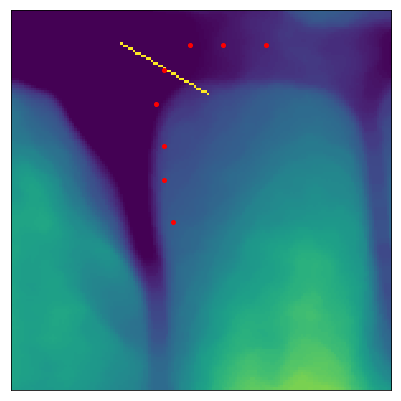

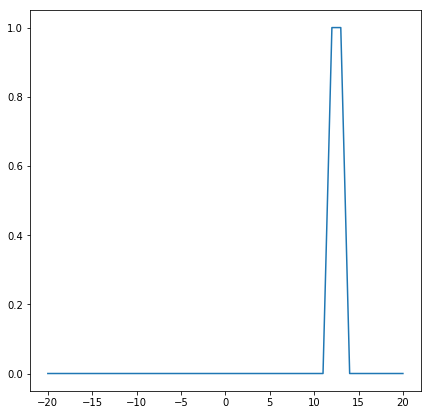

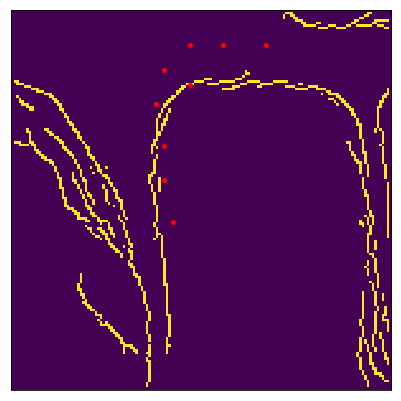

In [2]:
if __name__ == "__main__":

    piece = fm.load_img_piece()
    new_pice = piece[300:450,100:250]

    tooth = fm.load_tooth_of_piece()
    points = tooth
    
    #fm.show_with_points(piece, points)
    
    new_points = np.copy(points)
    new_points[:,0]=points[:,0]-100
    new_points[:,1]=points[:,1]-300
    
    a,b,c = new_points[0:3]
    
    rad = get_normal_angle(a,b,c)
    p1 = get_point_at_distance(b, 20, rad)
    p2 = get_point_at_distance(b, -20, rad)
    
    img_copy = new_pice.copy()
    
    p1 = np.array(p1,dtype=int)
    p2 = np.array(p2,dtype=int)
    make_line(img_copy, p1,p2)
    
    visualize_points = new_points.take([38,39,0,1,2,3,4,5],axis=0)
    proj = project_on(b, a,c)
    #new_visualize_points = np.append(visualize_points,proj).reshape(-1,2)
    
    show_with_points(img_copy,visualize_points)
    
    edges = get_points_on_angle_normal(b, rad, 20)
    #edge_img = prep.sobel(new_pice)
    edge_img = prep.canny(new_pice)
    strength = edge_strength_at_points(edges ,edge_img)
    
    #show_with_points(new_pice,np.append(edges,visualize_points).reshape(-1,2))
    
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.plot(np.arange(-20,21),strength)
    plt.show()
    
    p = strongest_edge_point_on_normal(a,b,c,20, edge_img)
    show_with_points(edge_img,np.append(visualize_points,p).reshape(-1,2))
    
#     piece = prep.median_filter(piece)
#     edge_img = prep.edge_detection_high(piece)
#     show_with_points(edge_img, points)
#     a,b,c = points
#     edges = edge_strength_on_normal(a,b,c,40, edge_img)

#     y = np.arange(-40,41)
#     plt.plot(y, normalize(edges))
#     plt.show()
    
#     new_point = strongest_edge_point_on_normal(a,b,c,40, edge_img)
#     new_new = np.append(points,new_point)
#     print(new_new.shape)
#     show_with_points(edge_img, new_new.reshape(4,2))
    
#     new_points, error = fit_measure(tooth, 30, edge_img)
#     fm.show_with_points(piece, new_points)